In [1]:
import heeps
from heeps.wavefront.get_array import show_wf, get_wf
from astropy.io import fits
import heeps.util.img_processing as impro
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

### Input parameters and functions

In [2]:
lt_dist_start = 188e-3                      # downstream of VPM (start of propagation between VPM and LS)
lt_diam_start = 80e-3
lt_dist_end_L = 36.5e-3                     # L-band, upstream of LS
lt_diam_end_L = 50e-3
lt_dist_end_N = 114e-3                      # N-band, upstream of LS
lt_diam_end_N = 57e-3
diam_nominal = 38.542                       # m
diam_nominal_METIS = 45.0e-3                # m
scaling = diam_nominal/diam_nominal_METIS
print('scaling = %.2f'%scaling)

scaling = 856.49


In [3]:
verbose = False
def add_lighttrap(wf0, case, show=True, **conf):
    wf = heeps.optics.fp_mask(deepcopy(wf0), verbose=verbose, **conf)
    if show is True:
        img = show_wf(wf, 'amp', npupil=1024)
    else:
        img = get_wf(wf, 'amp', npupil=1024)
    fits.writeto('ls_amp_%s.fits'%case, np.float32(img), overwrite=True)
    wf = heeps.optics.lyot_stop(wf, verbose=verbose, **conf)
    return heeps.optics.detector(wf, verbose=verbose, **conf)

def raw_contrast(case, pscale, psf_OFF, psfs, labels, band='L'):
    # image radius
    rim = psf_OFF.shape[-1] // 2
    # x axis in lam/D
    x = pscale*1e-3*np.arange(rim)
    # normalize by the peak of the off-axis PSF
    y1 = impro.get_radial_profile(psf_OFF, (rim,rim), 1)[:-1]
    peak = np.max(y1)
    plt.figure(figsize=(9.5, 4))
    for i, (psf_ON, label) in enumerate(zip(psfs, labels)):
        y2 = impro.get_radial_profile(psf_ON, (rim,rim), 1)[:-1]
        y2 /= peak
        lw = 2 if i==0 else 1
        ls = '-' if i==0 else '--'
        plt.plot(x, y2, label=label, linewidth=lw, linestyle=ls)
    plt.loglog()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.xlabel('Angular separation $[arcsec]$')
    plt.ylabel('raw contrast')
    plt.legend()
    if 'N' in band:
        plt.xlim(0.06, 1.2)
        plt.ylim(1e-8,1e-2)
        plt.xticks([0.06, 0.1, 0.2, 0.5, 1, 1.2])
    else:
        plt.xlim(0.02, 0.75)
        plt.ylim(1e-8,1e-2)
        plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
    plt.savefig('%s.png'%case, dpi=300, transparent=True);

# 1. L band

In [4]:
conf = dict(
    band = 'L',
    mode = 'CVC',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
    nframes = 1,
    hfov = 0.8,
    ls_dRext = 0.0209,
    ls_dRint = 0.09,
    ls_dRspi = 0.0245,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
# rescale to size of beam inside METIS
conf['focal'] /= scaling
conf['pupil_img_size'] /= scaling
conf['diam_nominal'] /= scaling
conf['diam_ext'] /= scaling
conf['diam_int'] /= scaling
conf['spi_width'] /= scaling
conf['seg_width'] /= scaling
conf['seg_gap'] /= scaling
# get off-axis PSF (without SCAO phase screen)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)
# add phase screen
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
wf0 = heeps.wavefront.add_errors(wf0, phase_screen=phase_screens[0], 
    verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0209, 0.09, 0.0245], ls_misalign=None
   extract PSF on the detector: ndet=293
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### No light trap

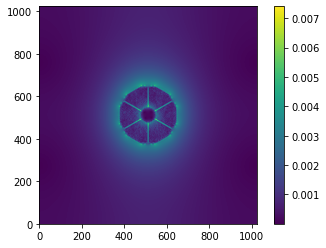

In [5]:
label1 = 'Lband_noLT'
psf1 = add_lighttrap(wf0, label1, **conf)

### Light trap at start of propagation (downstream of VPM, diverging beam)

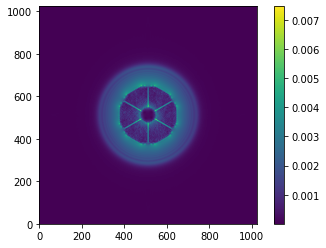

In [6]:
label2 = 'Lband_LTstart_%dmm'%(lt_diam_start*1e3)
psf2 = add_lighttrap(wf0, label2, **dict(conf, lt_dist_start=lt_dist_start,
    lt_diam_start=lt_diam_start/conf['diam_ext']))

### Light trap at end of propagation (upstream of LS, collimated beam)

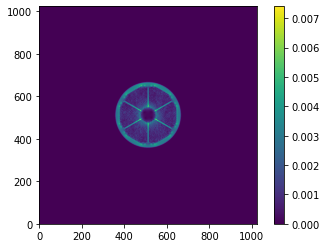

In [7]:
label3 = 'Lband_LTend_%dmm'%(lt_diam_end_L*1e3)
psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']))

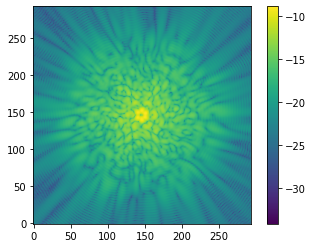

In [8]:
plt.imshow(np.log(psf3), origin='lower'); plt.colorbar()
plt.savefig('L_PSF.png', dpi=300, transparent=True);

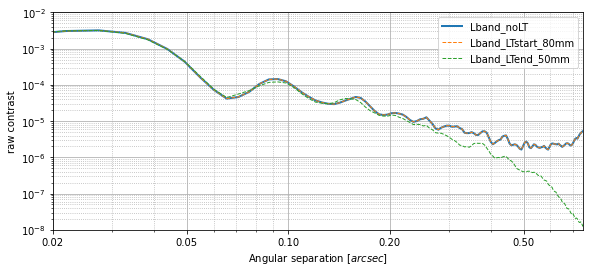

In [9]:
raw_contrast('L_raw_cc', conf['pscale'], psf_OFF, [psf1, psf2, psf3], [label1, label2, label3])

# show difference between noLT and LTend

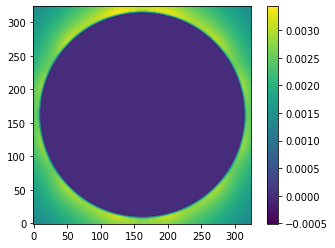

In [10]:
LS1 = fits.getdata('ls_amp_%s.fits'%label1)
LS3 = fits.getdata('ls_amp_%s.fits'%label3)
diff = (LS1-LS3)
fits.writeto('ls_amp_Lband_diff_1-3.fits', diff, overwrite=True)
crop = 350
cropped = diff[crop:-crop,crop:-crop]
plt.imshow((cropped), origin='lower');plt.colorbar();

# explore larger light traps

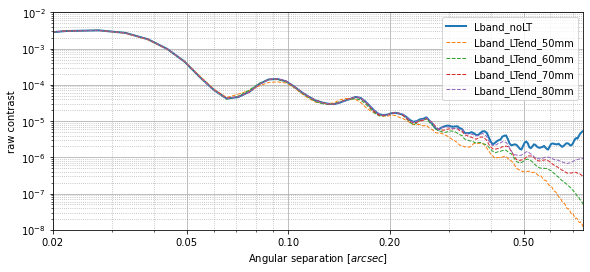

In [11]:
lt_diam_end_L = 60e-3
label4 = 'Lband_LTend_%dmm'%(lt_diam_end_L*1e3)
psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 70e-3
label5 = 'Lband_LTend_%dmm'%(lt_diam_end_L*1e3)
psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 80e-3
label6 = 'Lband_LTend_%dmm'%(lt_diam_end_L*1e3)
psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore', conf['pscale'], psf_OFF, [psf1, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6])

# 2. N band

In [12]:
conf = dict(
    band = 'N2',
    mode = 'CVC',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
    nframes = 1,
    hfov = 1.3,
    ls_dRext = 0.0268,
    ls_dRint = 0.09,
    ls_dRspi = 0.0357,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
# rescale to size of beam inside METIS
conf['focal'] /= scaling
conf['pupil_img_size'] /= scaling
conf['diam_nominal'] /= scaling
conf['diam_ext'] /= scaling
conf['diam_int'] /= scaling
conf['spi_width'] /= scaling
conf['seg_width'] /= scaling
conf['seg_gap'] /= scaling
# get off-axis PSF (without SCAO phase screen)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)
# add phase screen
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
wf0 = heeps.wavefront.add_errors(wf0, phase_screen=phase_screens[0], 
    verbose=True, **conf)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.3 arcsec (-> ndet=383, 20.53 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0268, 0.09, 0.0357], ls_misalign=None
   extract PSF on the detector: ndet=383
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### No light trap

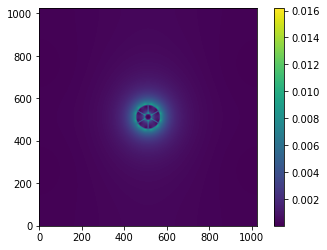

In [13]:
label1 = 'Nband_noLT'
psf1 = add_lighttrap(wf0, label1, **conf)

### Light trap before lens (diverging beam)

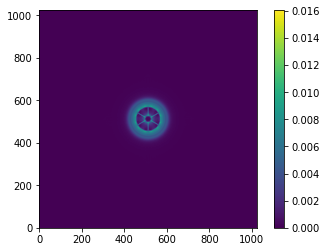

In [14]:
label2 = 'Nband_LTstart_%dmm'%(lt_diam_start*1e3)
psf2 = add_lighttrap(wf0, label2, **dict(conf, lt_dist_start=lt_dist_start,
    lt_diam_start=lt_diam_start/conf['diam_ext']))

### Light trap after lens (collimated beam)

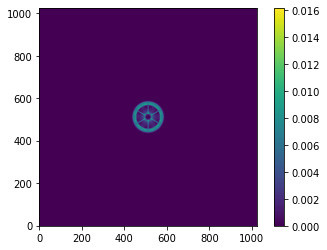

In [15]:
label3 = 'Nband_LTstart_%dmm'%(lt_diam_end_N*1e3)
psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_N,
    lt_diam_end=lt_diam_end_N/conf['diam_ext']))

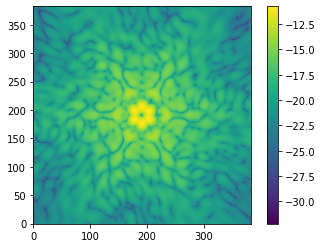

In [16]:
plt.imshow(np.log(psf3), origin='lower'); plt.colorbar()
plt.savefig('N_PSF.png', dpi=300, transparent=True);

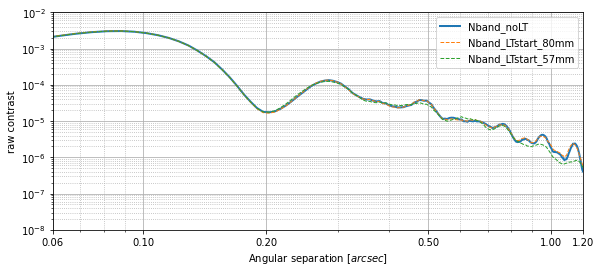

In [17]:
raw_contrast('N_raw_cc', conf['pscale'], psf_OFF, [psf1, psf2, psf3], [label1, label2, label3], band='N')